In [12]:
import numpy as np
import pandas as pd
import json as json
from scipy import stats
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [13]:
from o_plot import opl # a small local package dedicated to this project

In [14]:
# Prepare the data

In [15]:
# loading the data
file_name = 'Up_to_Belem_TE4AL2_data_new.json'
f = open(file_name)
All_data = json.load(f)
print(len(All_data))

148


## Note for the interpretation of the curves and definition of the statistical variables

The quantum state classifier (QSC) error rates $\widehat{r}_i$ in function of the number of experimental shots $n$ were determined for each highly entangled quantum state $\omega_i$ in the $\Omega$ set, with $i=1...m$.

The curves seen on the figures represents the mean of the QSC error rate $\widehat{r}_{mean}$ over the $m$ quantum states at each $n$ value.

This Monte Carlo simulation allowed to determine a safe shot number $n_s$ such that $\forall i\; \widehat{r}_i\le \epsilon_s$. The value of $\epsilon_s$ was set at 0.001.

$\widehat{r}_{max}$ is the maximal value observed among all the $\widehat{r}_i$ values for the determined  number of shots $n_s$.

Similarly, from the error curves stored in the data file, was computed the safe shot number $n_t$ such that $\widehat{r}_{mean}\le \epsilon_t$. The value of $\epsilon_t$ was set at 0.0005 after verifying that all $\widehat{r}_{mean}$ at $n_s$ were $\le \epsilon_s$ in the different experimental settings. 

Correspondance between variables names in the text and in the data base:

- $\widehat{r}_{mean}$: error_curve
- $n_s$: shots
- max ($\widehat{r}_i$) at $n_s$: shot_rate
- $\widehat{r}_{mean}$ at $n_s$: mns_rate
- $n_t$: m_shots
- $\widehat{r}_{mean}$ at $n_t$: m_shot_rate




In [16]:
# Calculate shot number 'm_shots' for mean error rate 'm_shot_rates' <= epsilon_t
len_data = len(All_data)
epsilon_t = 0.0005
window = 11
for i in range(len_data):            
    curve = np.array(All_data[i]['error_curve'])
    # filter the curve only for real devices:
    if All_data[i]['device']!="ideal_device":    
        curve = savgol_filter(curve,window,2) 
    # find the safe shot number:    
    len_c = len(curve)                               
    n_a = np.argmin(np.flip(curve)<=epsilon_t)+1                          
    if n_a == 1:
        n_a = np.nan
        m_r = np.nan
    else:
        m_r = curve[len_c-n_a+1]
    All_data[i]['min_r_shots'] = len_c-n_a
    All_data[i]['min_r'] = m_r

In [17]:
# find mean error rate at n_s
for i in range(len_data):
    i_shot = All_data[i]["shots"]
    if not np.isnan(i_shot):
        j = int(i_shot)-1        
        All_data[i]['mns_rate'] = All_data[i]['error_curve'][j]
    else:
        All_data[i]['mns_rate'] = np.nan

In [159]:
#defining the pandas data frame for statistics excluding from here ibmqx2 data
df_All= pd.DataFrame(All_data,columns=['shot_rates','shots', 'device', 'fidelity',
                                        'mitigation','model','id_gates',
                                        'QV', 'metric','error_curve',
                                        'mns_rate','min_r_shots',
                                        'min_r']).query("device != 'ibmqx2'")

# any shot number >= 488 indicates that the curve calculation 
# was ended after reaching n = 500, hence this data correction:
df_All.loc[df_All.shots>=488,"shots"]=np.nan

# add the variable neperian log of safe shot number: 
df_All['log_shots'] = np.log(df_All['shots'])
df_All['log_min_r_shots'] = np.log(df_All['min_r_shots'])

# add the delta shots variables 
# we know that we need 16 shots anyway in the ideal conditions for this case
df_All['d_shots'] = df_All['shots'] - 16 # this  is valid for both metrics


### Error rates in function of chosen $\epsilon_s$ and $\epsilon_t$

In [19]:
print("max mean error rate at n_s over all experiments =", round(max(df_All.mns_rate[:-2]),6))

max mean error rate at n_s over all experiments = 0.000515


In [20]:
print("min mean error rate at n_t over all experiments =", round(min(df_All.min_r[:-2]),6))

min mean error rate at n_t over all experiments = 0.000225


In [21]:
print("max mean error rate at n_t over all experiments =", round(max(df_All.min_r[:-2]),6))

max mean error rate at n_t over all experiments = 0.0005


<AxesSubplot:ylabel='Frequency'>

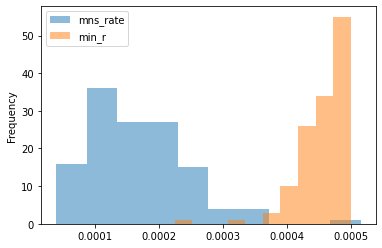

In [22]:
df_All.mns_rate[:-2].plot.hist(alpha=0.5, legend = True)
df_All.min_r[:-2].plot.hist(alpha=0.5, legend = True)

### Determine the options
Running sequentially these cells will end up with the main streaming options

In [80]:
# this for Jensen-Shannon metric 
s_metric = 'jensenshannon'
sm = np.array([96+16+16+16]) # added Quito and Lima and Belem
SAD=0
# ! will be unselected by running the next cell

In [107]:
# mainstream option for metric: squared euclidean distance
# skip this cell if you don't want this option
s_metric = 'sqeuclidean'
sm = np.array([97+16+16+16]) # added Quito and Lima and Belem
SAD=2   

## 1. Compare distribution models


In [171]:
# this for no mitigation
mit = 'no'
MIT=-4

In [172]:
# select data according to the options
df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]

<ipython-input-172-af347b9ea33a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]


In [173]:
print("mitigation:",mit,"  metric:",s_metric )
df_mod.groupby('device')[['d_shots','shots']].describe(percentiles=[0.5])

mitigation: no   metric: sqeuclidean


d_shots                                        shots          \
                count    mean         std   min   50%    max count    mean   
device                                                                       
ibmq_athens       4.0   30.00   14.628739  18.0  26.5   49.0   4.0   46.00   
ibmq_belem        4.0   43.00   27.141604  22.0  34.5   81.0   4.0   59.00   
ibmq_lima         4.0   89.75   91.928867  32.0  51.0  225.0   4.0  105.75   
ibmq_ourense      4.0   35.75   11.026483  22.0  36.0   49.0   4.0   51.75   
ibmq_quito        4.0  141.00  134.880194  33.0  96.5  338.0   4.0  157.00   
ibmq_santiago     4.0   34.50    9.327379  21.0  37.5   42.0   4.0   50.50   
ibmq_valencia     4.0   37.75   14.174508  21.0  40.0   50.0   4.0   53.75   
ibmq_vigo         4.0   28.50   13.771952  17.0  24.5   48.0   4.0   44.50   

                                               
                      std   min    50%    max  
device                                         
ibmq_athens     14.628739  34.0   42.5   65.0  
ibmq_belem      27.141604  38.0   50.5   97.0  
ibmq_lima       91.928867  48.0   67.0  241.0  
ibmq_ourense    11.026483  38.0   52.0   65.0  
ibmq_quito     134.880194  49.0  112.5  354.0  
ibmq_santiago    9.327379  37.0   53.5   58.0  
ibmq_valencia   14.174508  37.0   56.0   66.0  
ibmq_vigo       13.771952  33.0   40.5   64.0

## Ideal vs empirical model: 

## without mitigation

### excess shots for creation + Bob measurement

#### Paired t-test and Wilcoxon test

In [174]:
for depvar in ['d_shots' ]:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query("id_gates == 0.0").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2 with the ideal model, hence this exclusion:
    df_emp=df_mod.query("model == 'empirical' & id_gates == 0.0")
    df_ide=df_mod.query("model == 'ideal_sim' & id_gates == 0.0")  #.reindex_like(df_emp,'nearest')
    # back to numpy arrays from pandas: 
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")

    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")
# added for delta calculations
cb_shots_emp = np.asarray(df_emp[depvar])
cb_shots_ide = np.asarray(df_ide[depvar])

mitigation: no   metric: sqeuclidean variable: d_shots
           count    mean        std   min   50%    max
model                                                 
empirical    8.0  23.250   5.994045  17.0  21.5   33.0
ideal_sim    8.0  40.875  27.843632  19.0  34.0  105.0 

paired data
[21. 18. 21. 17. 22. 33. 32. 22.]
[ 39.  19.  50.  21.  36. 105.  32.  25.] 

Ttest_relResult(statistic=-2.0633865777506637, pvalue=0.07797431270417877)
WilcoxonResult(statistic=0.0, pvalue=0.017960477526078766) 



C:\Users\decpi\Anaconda3\envs\QK25\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\decpi\Anaconda3\envs\QK25\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### excess shots for creation + transmission time of 256  id gates + Bob measurement

#### Paired t-test and Wilcoxon test

In [175]:
for depvar in ['d_shots' ]:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query("id_gates == 256.0 ").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2   with the ideal model, hence their exclusion:
    df_emp=df_mod.query("model == 'empirical' & id_gates == 256.0 ")
    df_ide=df_mod.query("model == 'ideal_sim' & id_gates == 256.0")  #.reindex_like(df_emp,'nearest') 
    # back to numpy arrays from pandas: 
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")
    
    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")
# added for delta calculations
tb_shots_emp = np.asarray(df_emp[depvar])
tb_shots_ide = np.asarray(df_ide[depvar])

mitigation: no   metric: sqeuclidean variable: d_shots
           count     mean         std   min   50%    max
model                                                   
empirical    8.0   45.875   21.503737  28.0  36.0   88.0
ideal_sim    8.0  110.125  110.635098  42.0  49.0  338.0 

paired data
[36. 34. 31. 28. 36. 88. 70. 44.]
[ 42.  49.  49.  48.  49. 338. 225.  81.] 

Ttest_relResult(statistic=-2.031337223285547, pvalue=0.0817513058528155)
WilcoxonResult(statistic=0.0, pvalue=0.0078125) 



### excess shots for  transmission time of 256  id gates + Bob measurement

In [176]:

print("mitigation:",mit,"  metric:",s_metric)
d_tb_emp = tb_shots_emp-cb_shots_emp
d_tb_ide = tb_shots_ide-cb_shots_ide
print(np.mean(d_tb_emp), '+/-',np.std(d_tb_emp))
print(np.mean(d_tb_ide), '+/-', np.std(d_tb_ide))
print(d_tb_emp)
print(d_tb_ide)
print(stats.ttest_rel(tb_shots_emp-cb_shots_emp,tb_shots_ide-cb_shots_ide))
print(stats.wilcoxon(tb_shots_emp-cb_shots_emp,tb_shots_ide-cb_shots_ide))

mitigation: no   metric: sqeuclidean
22.625 +/- 14.815005062435855
69.25 +/- 85.23313616194115
[15. 16. 10. 11. 14. 55. 38. 22.]
[  3.  30.  -1.  27.  13. 233. 193.  56.]
Ttest_relResult(statistic=-1.7403785611738531, pvalue=0.12533964536100758)
WilcoxonResult(statistic=6.0, pvalue=0.109375)


## with mitigation

In [177]:
mit = 'yes'
MIT= 0

In [178]:
# select data according to the options
df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]

<ipython-input-178-af347b9ea33a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]


In [179]:
print("mitigation:",mit,"  metric:",s_metric )
df_mod.groupby('device')[['d_shots','shots']].describe(percentiles=[0.5])

mitigation: yes   metric: sqeuclidean


d_shots                                      shots          \
                count   mean        std   min   50%    max count    mean   
device                                                                     
ibmq_athens       4.0  24.75  10.078856  16.0  23.0   37.0   4.0   40.75   
ibmq_belem        4.0  23.00  15.077577   9.0  20.5   42.0   4.0   39.00   
ibmq_lima         4.0  34.50  25.722882  13.0  29.5   66.0   4.0   50.50   
ibmq_ourense      4.0  18.75   4.112988  14.0  18.5   24.0   4.0   34.75   
ibmq_quito        4.0  84.50  72.399355  23.0  63.0  189.0   4.0  100.50   
ibmq_santiago     4.0  22.75   8.180261  11.0  25.0   30.0   4.0   38.75   
ibmq_valencia     4.0  16.75   5.737305   9.0  18.0   22.0   4.0   32.75   
ibmq_vigo         4.0  16.50   7.724420   9.0  16.0   25.0   4.0   32.50   

                                             
                     std   min   50%    max  
device                                       
ibmq_athens    10.078856  32.0  39.0   53.0  
ibmq_belem     15.077577  25.0  36.5   58.0  
ibmq_lima      25.722882  29.0  45.5   82.0  
ibmq_ourense    4.112988  30.0  34.5   40.0  
ibmq_quito     72.399355  39.0  79.0  205.0  
ibmq_santiago   8.180261  27.0  41.0   46.0  
ibmq_valencia   5.737305  25.0  34.0   38.0  
ibmq_vigo       7.724420  25.0  32.0   41.0

### excess shots for creation 

#### Paired t-test and Wilcoxon test

In [180]:
for depvar in ['d_shots' ]:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query("id_gates == 0.0").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2 with the ideal model, hence this exclusion:
    df_emp=df_mod.query("model == 'empirical' & id_gates == 0.0 ")
    df_ide=df_mod.query("model == 'ideal_sim' & id_gates == 0.0")  #.reindex_like(df_emp,'nearest')
    # back to numpy arrays from pandas: 
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")

    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")
# added for delta calculations
c_shots_emp = np.asarray(df_emp[depvar])
c_shots_ide = np.asarray(df_ide[depvar])

mitigation: yes   metric: sqeuclidean variable: d_shots
           count   mean        std   min   50%   max
model                                               
empirical    8.0  13.00   4.810702   9.0  12.0  23.0
ideal_sim    8.0  23.75  19.255797  11.0  17.5  70.0 

paired data
[11. 16.  9.  9. 14. 23. 13.  9.]
[25. 17. 22. 11. 18. 70. 14. 13.] 

Ttest_relResult(statistic=-1.95830614638339, pvalue=0.0910466335786169)
WilcoxonResult(statistic=0.0, pvalue=0.0078125) 



### excess shots for creation + transmission time of 256  id gates

#### Paired t-test and Wilcoxon test

In [181]:
for depvar in ['d_shots' ]:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query("id_gates == 256.0 ").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2   with the ideal model, hence their exclusion:
    df_emp=df_mod.query("model == 'empirical' & id_gates == 256.0 ")
    df_ide=df_mod.query("model == 'ideal_sim' & id_gates == 256.0")  #.reindex_like(df_emp,'nearest') 
    # back to numpy arrays from pandas: 
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")
    
    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")
# added for delta calculations
t_shots_emp = np.asarray(df_emp[depvar])
t_shots_ide = np.asarray(df_ide[depvar])

mitigation: yes   metric: sqeuclidean variable: d_shots
           count  mean        std   min   50%    max
model                                               
empirical    8.0  30.5  13.638182  16.0  28.5   56.0
ideal_sim    8.0  53.5  56.742526  20.0  31.0  189.0 

paired data
[30. 29. 16. 21. 19. 56. 45. 28.]
[ 25.  37.  20.  25.  24. 189.  66.  42.] 

Ttest_relResult(statistic=-1.4423373664478383, pvalue=0.19241441998644923)
WilcoxonResult(statistic=3.5, pvalue=0.0390625) 



### excess shots for  transmission time of 256  id gates

In [184]:
print("mitigation:",mit,"  metric:",s_metric)
d_t_emp = t_shots_emp-c_shots_emp
d_t_ide = t_shots_ide-c_shots_ide

print(np.mean(d_t_emp), np.std(d_t_emp))
print(np.mean(d_t_ide), '+/-', np.std(d_t_ide))
print(d_t_emp)
print(d_t_ide)
print(stats.ttest_rel(t_shots_emp-c_shots_emp,t_shots_ide-c_shots_ide))
print(stats.wilcoxon(t_shots_emp-c_shots_emp,t_shots_ide-c_shots_ide))

mitigation: yes   metric: sqeuclidean
17.5 9.82344135219425
29.75 +/- 37.51916177102042
[19. 13.  7. 12.  5. 33. 32. 19.]
[  0.  20.  -2.  14.   6. 119.  52.  29.]
Ttest_relResult(statistic=-1.080986722892825, pvalue=0.31553203528646223)
WilcoxonResult(statistic=10.0, pvalue=0.3125)
